<div align="center">
    <img src='https://media-exp1.licdn.com/dms/image/C561BAQFV4oU27rzxaQ/company-background_10000/0/1562869489836?e=2147483647&v=beta&t=OMHL6Izxqw7r8S5fn9gDQM1hNMKgo3yqMlH1F3Iwm9o' style='height:300px;'>
</div>


<center><h1 style='font-size:35px'>Clasificación de fraudes</h1></center>

---

**Fecha de creación: 27/07/2022**

**Grupo: fraud detection (2)**

**Integrantes**:
* Maria Mercedes Silva
* Agustin Trulli
* Ernesto Romero

**Resumen**

El objetivo del presente notebook es probar diferentes alternativas para entrenar un modelo de aprendizaje automático capaz de predecir transacciones fraudulentas realizadas con una tarjeta de credito.

# Setup inicial

In [2]:
import json
import os
import warnings
import time

import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (f1_score, precision_score, recall_score, 
                             roc_auc_score, plot_confusion_matrix)

warnings.filterwarnings('ignore')

In [3]:
# Reading data
ROOT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(ROOT_PATH, 'data', 'raw')

df1 = pd.read_csv(os.path.join(DATA_PATH, 'fraud_data_pt1.csv'), index_col=0)
df2 = pd.read_csv(os.path.join(DATA_PATH, 'fraud_data_pt12.csv'), index_col=0)

df = pd.concat([df1, df2], ignore_index=True)

del df1, df2

# Preprocesamiento

### Creamos la feature 'last_hour_transactions'.

In [12]:
def acc_hour_1(df):
    print('Calculating the accumulate fraud cases in the last hour for {} payments.'.format(df.shape[0]))
    start = time.time()
    df_time = df.Time.to_numpy()
    df_filtered = df[['Time', 'Class']]
    response = [] 
    for t in df_time:
        df_t = df_filtered[(df_filtered.Time > (t -3600)) & (df_filtered.Time <= t)]
        if df_t.Class.value_counts()[0] == df_t.shape[0]:
            response.append(0)
        else:
            response.append(df_t.Class.value_counts()[1])
    end = time.time()
    print('Returning response. Elpased time:', end - start)
    return response

In [13]:
df['last_hour_transactions'] = acc_hour_1(df)

Calculating the accumulate fraud cases in the last hour for 284807 payments.
Returning response. Elpased time: 441.8873653411865


# Entrenamiento del modelo

**Aspectos generales**:

* Vamos a entrenar Random Forest y Logistic Regression
* Elejimos AuCRoc, Precission, Recall y F1Score como metricas. Accuraccy no es adecuada para sets de datos desbalanceados como este.
* Balancearemos las clases mediante el parámetro 'class_weight' presente en muchos de los modelos de Sklearn e incluso otras librerias de Machine Learning. A grandes rasgos, este parámetro realiza una ponderación en la función de costo a partir de la frecuencia de las clases: Hace que una clasificación erronea de una clase minoritaria (el fraude en nuestro caso) sea más penalizado que un error de clasificación de clase mayoritaria.

*ref*: https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)

In [15]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

target = 'Class'

X_train = df_train.drop(target, axis=1)
y_train = df_train[[target]]
X_test = df_test.drop(target, axis=1)
y_test = df_test[[target]]

## Utils

In [16]:
def process_metrics(y_true, y_pred, y_proba):
    """Compute metrics based on model predictions.
        Args:
            - y_true: ground truth.
            - y_pred: prediction.
            - y_proba: predict probabilities.
        Returns:
            - metrics: dictionary with all computed metrics.
    """
    metrics = {}

    metrics['precision_score'] = precision_score(y_true, y_pred)
    metrics['recall_score'] = recall_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    metrics['roc_auc_score'] = roc_auc_score(y_true, y_proba[:, 1])

    return metrics

In [17]:
def run_experiment(predictor):
    """Run the base experiment for all the models.
       Args:
           - predictor: predictor instance.
       Returns:
           - Experiment metrics.
    """
    # Training model
    predictor.fit(X_train, y_train)

    # Train predictions
    y_train_pred = predictor.predict(X_train)
    y_train_proba = predictor.predict_proba(X_train)

    # Test predictions
    y_test_pred = predictor.predict(X_test)
    y_test_proba = predictor.predict_proba(X_test)

    # Computing train and test metrics
    metrics = {}
    metrics['train_metrics'] = process_metrics(y_train, y_train_pred, y_train_proba)
    metrics['test_metrics'] = process_metrics(y_test, y_test_pred, y_test_proba)
    
    return metrics, y_test_pred

In [18]:
def plot_train_and_test_cm(predictor):
    """Plot train and test confusion matrix
       Args:
           - Sklearn predictor
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))

    plot_confusion_matrix(predictor, X_train, y_train, ax=axes[0], cmap='Blues', colorbar=False)
    axes[0].title.set_text('Train matrix')
    plot_confusion_matrix(predictor, X_test, y_test, ax=axes[1], cmap='Blues', colorbar=False)
    axes[1].title.set_text('Test matrix')

In [19]:
def print_as_json(dic):
    print(json.dumps(dic, indent=4))

## Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### Sin balancear

In [20]:
%%time
imb_lr_predictor = LogisticRegression(random_state=42, n_jobs=-1)

imb_lr_metrics, imb_lr_test_preds = run_experiment(imb_lr_predictor)

Wall time: 19.2 s


In [21]:
print('Metricas obtenidas:')
print_as_json(imb_lr_metrics)

Metricas obtenidas:
{
    "train_metrics": {
        "precision_score": 0.678082191780822,
        "recall_score": 0.5561797752808989,
        "f1_score": 0.611111111111111,
        "roc_auc_score": 0.8896865390539324
    },
    "test_metrics": {
        "precision_score": 0.6422764227642277,
        "recall_score": 0.5808823529411765,
        "f1_score": 0.6100386100386102,
        "roc_auc_score": 0.9171092435004645
    }
}


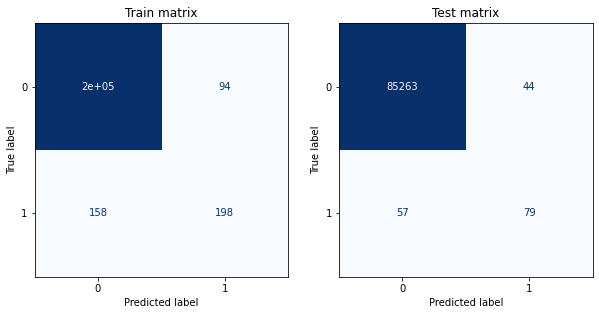

In [22]:
plot_train_and_test_cm(imb_lr_predictor)

### Balanceado

In [23]:
%%time
bal_lr_predictor = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1)

bal_lr_metrics, bal_lr_test_preds = run_experiment(bal_lr_predictor)

Wall time: 16 s


In [24]:
print_as_json(bal_lr_metrics)

{
    "train_metrics": {
        "precision_score": 0.04585280373831776,
        "recall_score": 0.8820224719101124,
        "f1_score": 0.08717379233759023,
        "roc_auc_score": 0.9723911852789839
    },
    "test_metrics": {
        "precision_score": 0.042219952332311884,
        "recall_score": 0.9117647058823529,
        "f1_score": 0.08070289619264563,
        "roc_auc_score": 0.9815006819659651
    }
}


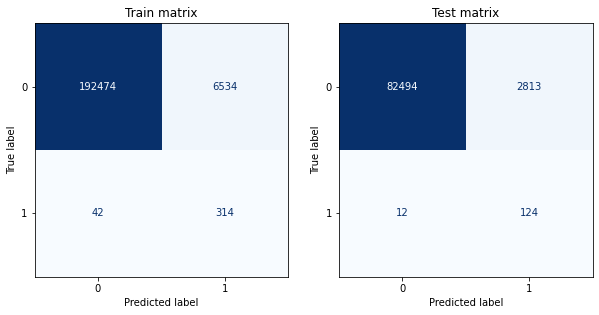

In [25]:
plot_train_and_test_cm(bal_lr_predictor)

**Como podemos ver, el modelo balanceado es capaz de encontrar una mayor cantidad de fraudes, pero a costa de un mayor número de falsos positivos. Sería un buen ejercicio evaluar el impacto de estos falsos positivos y parangonar el mismo con el $ que nos ahorrariamos por cada fraude.**

## Random Forest 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### Sin balancear

In [26]:
%%time
imb_rf_predictor = RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

imb_rf_metrics, imb_rf_test_preds = run_experiment(imb_rf_predictor)

Wall time: 27.3 s


In [27]:
print_as_json(imb_rf_metrics)

{
    "train_metrics": {
        "precision_score": 1.0,
        "recall_score": 0.8230337078651685,
        "f1_score": 0.9029275808936826,
        "roc_auc_score": 0.9944664016668745
    },
    "test_metrics": {
        "precision_score": 0.9553571428571429,
        "recall_score": 0.7867647058823529,
        "f1_score": 0.8629032258064515,
        "roc_auc_score": 0.978755967202195
    }
}


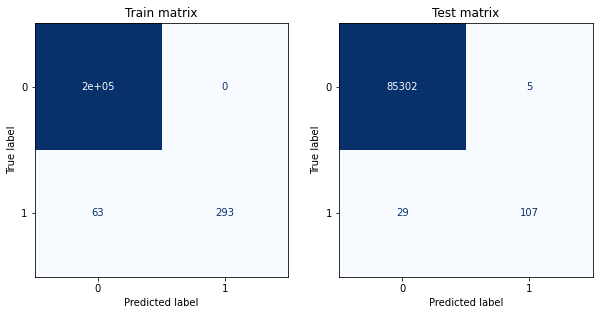

In [28]:
plot_train_and_test_cm(imb_rf_predictor)

### Balanceado

In [29]:
%%time
bal_rf_predictor = RandomForestClassifier(max_depth=10, class_weight='balanced', 
                                          n_jobs=-1, random_state=42)

bal_rf_metrics, bal_rf_test_preds = run_experiment(bal_rf_predictor)

Wall time: 24.3 s


In [30]:
print_as_json(bal_rf_metrics)

{
    "train_metrics": {
        "precision_score": 0.9020618556701031,
        "recall_score": 0.9831460674157303,
        "f1_score": 0.9408602150537635,
        "roc_auc_score": 0.9999588549091133
    },
    "test_metrics": {
        "precision_score": 0.8529411764705882,
        "recall_score": 0.8529411764705882,
        "f1_score": 0.8529411764705882,
        "roc_auc_score": 0.985125694808853
    }
}


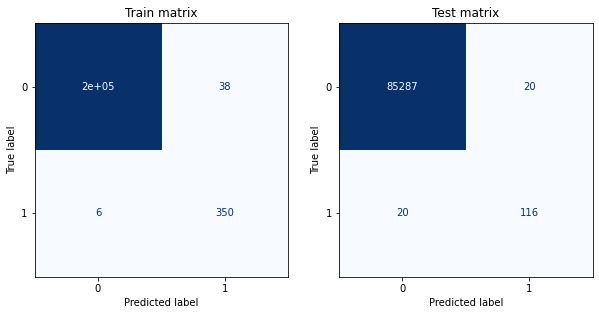

In [31]:
plot_train_and_test_cm(bal_rf_predictor)

El RandomForest balanceado mejora la performance, aumentando un poco la cantidad de fraudes encontrados a costa de una despreciable cantidad de falsos positivos.

**Como era de esperar, la performance de RandomForest es muy superior a la de la regresión logística en cuanto a la cantidad de falsos positivos. El primero de estos no supone una relación lineal entre variables y es capaz de encontrar relaciones mas complejas en los datos, construyendo pronteras de decisión no lineales (entre otras)**.

## Usando GridSearch para busqueda hiperparamétrica

Grid Search es una tecnica de aprendizaje automático para encontra el conjunto de hiperparámetros de un modelo que mejor performa en función de una métrica en particular. En palabras mas sencillas, probará todas las combinaciones de hiperparámetros que le indiquemos y se quedará con aquella que maximice (o minimice) la métrica elegida.

El GridSearchCV de Sklearn, como su nombre lo indica, posee una particularidad: Realiza Cross-validation sobre el conjunto de datos de entrenamiento.

Una intuición sencilla sobre como funciona cross-validation:

<div align="center">
    <img src='https://upload.wikimedia.org/wikipedia/commons/f/f2/K-fold_cross_validation.jpg' style=\'height:300px;'>
</div>

A grandes rasgos, cross validation le permite al modelo realizar una mayor *generalización* sobre los datos de entrada. Nos permite generar modelos 'mas robustos' y métricas 'mas confiables'.

*ref. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html*

In [ ]:
%%time
# Ejemplo sencillo de una optimización con grid search
# Nota: Grid Search hace una busqueda bruta (prueba todo), 
# otros optimizadores como Optuna pueden resultar mas apropiados para datasets grandes.
params = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 20, 30],
    'class_weight': ['balanced']
}

grid_search_rf_clf = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    scoring='f1',
    cv=3,
    return_train_score=True,
    n_jobs=-1
)

grid_search_rf_metrics = run_experiment(grid_search_rf_clf)

In [ ]:
grid_search_rf_metrics

### Mejor conjunto de hiperparámetros encontrado

In [ ]:
grid_search_rf_clf.best_params_

### Detalle de las metricas por fold (cross-val)

In [ ]:
selected_cols = ['rank_test_score', 'mean_fit_time', 'param_max_depth', 'param_n_estimators',
                 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score']

cv_results = pd.DataFrame(grid_search_rf_clf.cv_results_)[selected_cols]
cv_results.sort_values(by='rank_test_score')

### Matriz de confusion

In [ ]:
plot_train_and_test_cm(grid_search_rf_clf)

La optimización hiperparamétrica no altera prácticamente nada los resultados obtenidos previamente. Este esta overfiteado.

# Buscando una métrica de negocio (KPI)

Análisis realizado sobre el conjunto de test.

In [ ]:
df_preds = df_test[['Amount', 'Class']].rename(columns={
    'Amount': 'amount',
    'Class': 'y_true'
}).copy()

df_preds['imb_lr_pred'] = imb_lr_test_preds
df_preds['bal_lr_pred'] = bal_lr_test_preds
df_preds['imb_rf_pred'] = imb_rf_test_preds
df_preds['bal_rf_pred'] = bal_rf_test_preds

In [ ]:
imb_lr = (df_preds.y_true == 1) & (df_preds.imb_lr_pred == 1)
bal_lr = (df_preds.y_true == 1) & (df_preds.bal_lr_pred == 1)
imb_rf = (df_preds.y_true == 1) & (df_preds.imb_rf_pred == 1)
bal_rf = (df_preds.y_true == 1) & (df_preds.bal_rf_pred == 1)

imb_lr_amount = df_preds[imb_lr].amount.sum()
bal_lr_amount = df_preds[bal_lr].amount.sum()
imb_rf_amount = df_preds[imb_rf].amount.sum()
bal_rf_amount = df_preds[bal_rf].amount.sum()

print(f'Monto de fraudes encontrados por Logistic Regression (sin balancear): ${round(imb_lr_amount, 2)}\n')
print(f'Monto de fraudes encontrados por Logistic Regression (balanceada): ${round(bal_lr_amount, 2)}\n')
print(f'Monto de fraudes encontrados por Random Forest (sin balancear): ${round(imb_rf_amount, 2)}\n')
print(f'Monto de fraudes encontrados por Random Forest (balanceado): ${round(bal_rf_amount, 2)}')

**Si bien el Random Forest presenta una pequeña diferencia con la LR balanceada, hay que tener en cuenta el costo generado por los falsos positivos.**

In [ ]:
monto_bajo = df_preds.amount <= 30
monto_medio = (df_preds.amount > 30) & (df_preds.amount <= 50)
monto_alto = df_preds.amount > 50

df_preds.loc[monto_bajo, 'amount_type'] = 'low'
df_preds.loc[monto_medio, 'amount_type'] = 'intermediate'
df_preds.loc[monto_alto, 'amount_type'] = 'high'

imb_lr_frauds = df_preds[imb_lr].amount_type.value_counts().to_frame()
imb_lr_frauds['model'] = 'Imbalanced LR'

bal_lr_frauds = df_preds[bal_lr].amount_type.value_counts().to_frame()
bal_lr_frauds['model'] = 'Balanced LR'

imb_rf_frauds = df_preds[imb_rf].amount_type.value_counts().to_frame()
imb_rf_frauds['model'] = 'Imbalanced RF'

bal_rf_frauds = df_preds[bal_rf].amount_type.value_counts().to_frame()
bal_rf_frauds['model'] = 'Balanced RF'

df_frauds = pd.concat([imb_lr_frauds, bal_lr_frauds, imb_rf_frauds, bal_rf_frauds])
df_frauds = df_frauds.reset_index().rename(columns={
    'index': 'amount_type',
    'amount_type': 'n_frauds'
})

In [ ]:
fig = px.bar(df_frauds, x='model', y='n_frauds', 
             color='amount_type', barmode='group', text='n_frauds')

fig.update_traces(textfont_size=12, textposition="outside")

fig.update_layout(
    title='Amount type distribution per model prediction',
    xaxis_title='Model',
    yaxis_title='Frauds amount',
    legend_title='Amount type',
)

fig.show()

No se observa una diferencia significativa en el tipo de fraude encontrado en el set de test.

<center><h1 style='font-size:35px'>Preguntas</h1></center>

* -

<center><h1 style='font-size:35px'>Conclusiones</h1></center>

* El modelo balanceado de LR es capaz de encontrar una mayor cantidad de fraudes, pero a costa de un mayor número de falsos positivos. Sería un buen ejercicio evaluar el impacto de estos falsos positivos y parangonar el mismo con el $ que nos ahorrariamos por cada fraude.

* Como era de esperar, la performance de RandomForest es muy superior a la de la regresión logística. El primero de estos no supone una relación lineal entre variables y es capaz de encontrar relaciones mas complejas en los datos, construyendo pronteras de decisión no lineales (entre otras).
* La optimización hiperparamétrica no altera prácticamente nada los resultados obtenidos previamente.
* No se observa una diferencia significativa en el tipo de fraude encontrado en el dataset de test.

<center><h1 style='font-size:35px'>Trabajo futuro</h1></center>

* -